## VirES - magnetic model benchmark

Assess perfomance of the VirES magnetic model evaluation and other parameters wrt. the plain data rerival. 
Get per sample times.

See also [VirES Python Client](https://github.com/ESA-VirES/VirES-Python-Client)

In [2]:
from viresclient import SwarmRequest

request = SwarmRequest()


SERVER_URL = "https://vires.services"
OWS_URL = f"{SERVER_URL}/ows"
HAPI_URL = f"{SERVER_URL}/hapi"

In [3]:
import requests
from viresclient._wps.time_util import parse_datetime

def get_collection_date_range(collection):
    """ Get collection start and stop dates. """
    info = requests.get(f"{HAPI_URL}/info?dataset={collection}").json()
    return {
        "startDate": parse_datetime(info["startDate"]),
        "stopDate": parse_datetime(info["stopDate"]),
    }
    
print(get_collection_date_range("SW_OPER_MAGA_LR_1B"))


{'startDate': datetime.datetime(2013, 11, 25, 11, 2, 52), 'stopDate': datetime.datetime(2022, 11, 5, 23, 59, 59)}


In [4]:
from datetime import datetime


def get_request_time(collection, start_time, end_time, auxiliaries=None, models=None, filter=None):
    request = SwarmRequest(OWS_URL)
    request.set_collection(collection)
    request.set_products(
        measurements=["B_NEC"],
        auxiliaries=auxiliaries,
        models=models,
    )
    if filter:
        request.add_filter(filter)
    request_start = datetime.now()
    data = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=False,
    )
    request_stop = datetime.now()
    xdata = data.as_xarray() 
    size = xdata["Timestamp"].shape[0]
    print(size, list(xdata))
    # time per sample in seconds
    return (request_stop - request_start).total_seconds() / size


In [7]:
import random
from datetime import timedelta

COLLECTION = {
    "A": "SW_OPER_MAGA_LR_1B",
    "B": "SW_OPER_MAGB_LR_1B",
    "C": "SW_OPER_MAGC_LR_1B",
}

def rndm_collection():
    rndm_col = random.choice(list(COLLECTION.values()))
    return(rndm_col)

def rndm_date():
    time_span = get_collection_date_range(rndm_collection())
    start_date = list((time_span.items()))[0][1]
    stop_date = list((time_span.items()))[1][1]
    
    num_days = (stop_date - start_date)
    rand_sec = (num_days.days *24*60*60) + num_days.seconds
    random_sec = random.randrange(rand_sec)
    
    return start_date + timedelta(seconds = random_sec)

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['Collection', 'Start time', 'End time','Model','Actual time'])

for _ in range(10):
    random_start_date = rndm_date()
    startdate_plus_hour = random_start_date + timedelta(hours=1)
    random_end_date = random_start_date + timedelta(days=+1)
    random_collection = rndm_collection()
        
        
    # plain data request
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
    )
    # print(f"{time:e} s per sample")
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : 'Plain data', "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])

    # plain data request with filter
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        filter="Flags_B != 255", # strip no-dadata values
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "Flags_B != 255", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])



    # plain data request with Quasi-Dipole Latitude (QDLatitude)
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        auxiliaries=["QDLat"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "QDLat", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])
    

    # plain data request with Magnetic Local Time (MLT)
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        auxiliaries=["MLT"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "MLT", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])


    # plain data request with QD-coordinates
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        auxiliaries=["MLT", "QDLat"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "MLT, QDLat", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])


    # plain data request with CHAOS-Core model
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["CHAOS-Core"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "CHAOS-Core", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])


    # plain data request with CHAOS-Static model
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["CHAOS-Static"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "CHAOS-Static", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])


    # plain data request with CHAOS-MMA model (CHAOS-MMA-Primary + CHAOS-MMA-Secondary)
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["CHAOS-MMA"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "CHAOS-MMA", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])


    # plain data request with CHAOS-MMA-Primary model
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["CHAOS-MMA-Primary"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "CHAOS-MMA-Primary", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])

    
    # plain data request with CHAOS-MMA-Secondary model
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["CHAOS-MMA-Secondary"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "CHAOS-MMA-Secondary", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])
    
    
    # plain data request with CHAOS (complete) model (CHAOS-Core + CHAOS-Static + CHAOS-MMA-Primary + CHAOS-MMA-Secondary)
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["CHAOS"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "CHAOS", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])

    
    # plain data request with CHAOS (complete) model (CHAOS-Core + CHAOS-Static + CHAOS-MMA-Primary + CHAOS-MMA-Secondary) / short request
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = startdate_plus_hour,
        models=["CHAOS"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": startdate_plus_hour, "Model" : "CHAOS_1h", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])
    
    
    # plain data request with MIO_SHA_2C
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["MIO_SHA_2C"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "MIO_SHA_2C", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])
    
    # plain data request with MIO_SHA_2C-Primary
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["MIO_SHA_2C-Primary"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "MIO_SHA_2C-Primary", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])
    
    # plain data request with MIO_SHA_2C-Secondary
    time = get_request_time(
        collection=random_collection,
        start_time = random_start_date, # both iso-date/time string or datetime.datetime object is accepted
        end_time = random_end_date,
        models=["MIO_SHA_2C-Secondary"],
    )
    new_row = {"Start time": random_start_date, "Collection": random_collection, "End time": random_end_date, "Model" : "MIO_SHA_2C-Secondary", "Actual time": f'{time:e}'}
    df= pd.concat([df, pd.DataFrame([new_row])])
df.to_csv('file_name.csv', encoding='utf-8', index=False)
    


In [12]:
model_one = df[df["Model"]=='QDLat']
print(model_one)


           Collection           Start time             End time  Model  \
0  SW_OPER_MAGA_LR_1B  2020-05-04 15:28:17  2020-05-05 15:28:17  QDLat   
0  SW_OPER_MAGA_LR_1B  2020-03-19 09:08:20  2020-03-20 09:08:20  QDLat   
0  SW_OPER_MAGA_LR_1B  2019-03-12 08:47:33  2019-03-13 08:47:33  QDLat   
0  SW_OPER_MAGA_LR_1B  2016-11-11 14:49:59  2016-11-12 14:49:59  QDLat   
0  SW_OPER_MAGA_LR_1B  2020-12-10 11:42:17  2020-12-11 11:42:17  QDLat   
0  SW_OPER_MAGB_LR_1B  2015-12-17 16:10:20  2015-12-18 16:10:20  QDLat   
0  SW_OPER_MAGC_LR_1B  2019-06-16 08:23:49  2019-06-17 08:23:49  QDLat   
0  SW_OPER_MAGC_LR_1B  2018-12-23 21:19:00  2018-12-24 21:19:00  QDLat   
0  SW_OPER_MAGC_LR_1B  2020-02-17 09:52:17  2020-02-18 09:52:17  QDLat   
0  SW_OPER_MAGC_LR_1B  2016-02-20 10:03:50  2016-02-21 10:03:50  QDLat   

    Actual time  
0  4.698044e-06  
0  6.354028e-06  
0  4.600706e-06  
0  4.550301e-06  
0  4.505104e-06  
0  4.548171e-06  
0  4.426389e-06  
0  4.565035e-06  
0  4.453819e-06  
0  4.

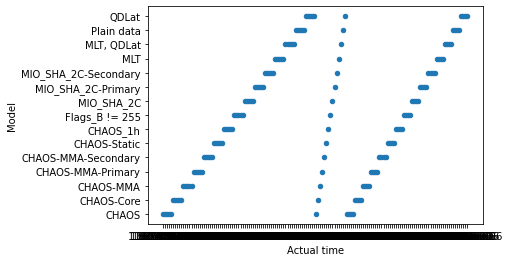

In [13]:
import matplotlib.pyplot as plt
df.plot(kind = 'scatter', x = 'Actual time', y = 'Model')
plt.show()